## Plotting SnowCam image data



In [137]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data=pd.read_csv('/Users/cdurkin/Projects/SnowCam/Snowcam_processed/All_particle_measurements.csv')

In [138]:
#Add image order number to the dataframe

number_list=[]
for name in data.file_name:
    number=name.split('-')
    number_list.append(int(number[0]))
data['number_list']=np.array(number_list)    

In [139]:
#Sort the dataframe based on the image order
data=data.sort_values(by='number_list')

#Remove data collected during the first six images when instrument was shifting around 
#and remove data collected at the end when it was recovered on the ship
data=data[data.number_list>6]
data=data[data.number_list<147]

In [140]:
#Group all particle measurements from each image

total_area=data['Area'].groupby(data.file_name,sort=False).sum()
image_values=data['median_image_value'].groupby(data.file_name,sort=False).max()
order_number=data['number_list'].groupby(data.file_name,sort=False).max()

<IPython.core.display.Javascript object>


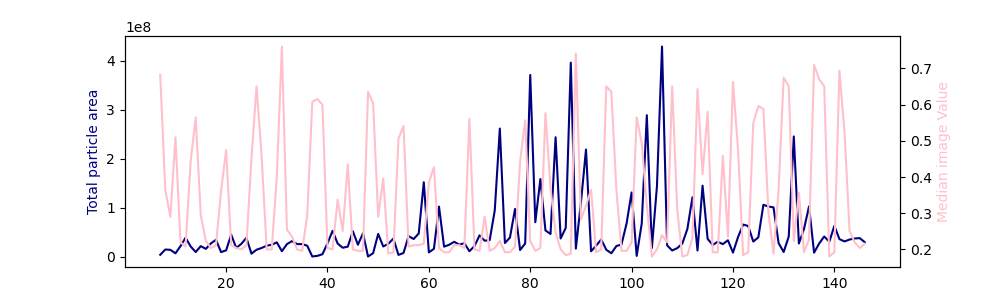

Text(0, 0.5, 'Median image Value')

In [141]:
plt.figure(figsize=(10,3))
plt.plot(np.array(order_number),total_area,color='navy')
plt.ylabel('Total particle area',color='navy')
plt.twinx()
plt.plot(np.array(order_number),image_values,color='pink')
plt.ylabel('Median image Value',color='pink')

## Median image value is the "HSV" color value of the image.  Images collected with bright backlighting during the day have a high median value (relatively light colors).

## There is clearly an effect of lightness on the ability to detect particles on the imaging plate


<IPython.core.display.Javascript object>


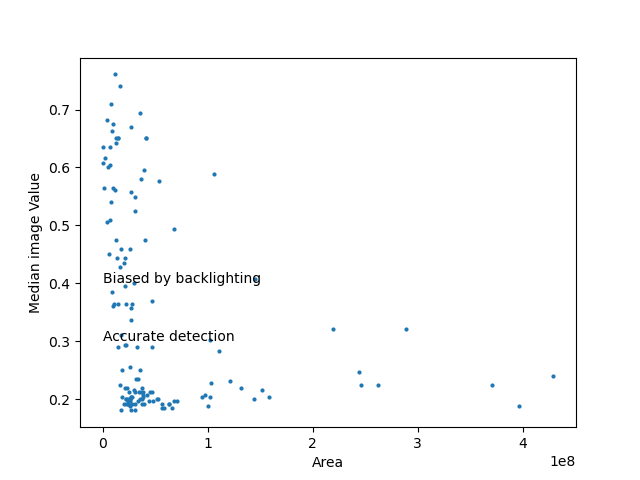

Text(200000, 0.3, 'Accurate detection')

In [142]:
plt.figure()
plt.plot(total_area,image_values,lw=0,marker='o',ms=2)
plt.xlabel('Area')
plt.ylabel('Median image Value')
plt.plot([0,300000],[0.35,0.35],color='hotpink')
plt.text(200000,0.4,'Biased by backlighting')
plt.text(200000,0.3,'Accurate detection')

## Used a median color value of 0.35 as the cut off for filtering out unuseful images

In [143]:
data_filtered=data[data.median_image_value<0.35]

In [144]:
#group data by image

total_area_filtered=data_filtered['Area'].groupby(data_filtered.file_name,sort=False).sum()
image_values_filtered=data_filtered['median_image_value'].groupby(data_filtered.file_name,sort=False).max()

order_number_filtered=data_filtered['number_list'].groupby(data_filtered.file_name,sort=False).max()

<IPython.core.display.Javascript object>


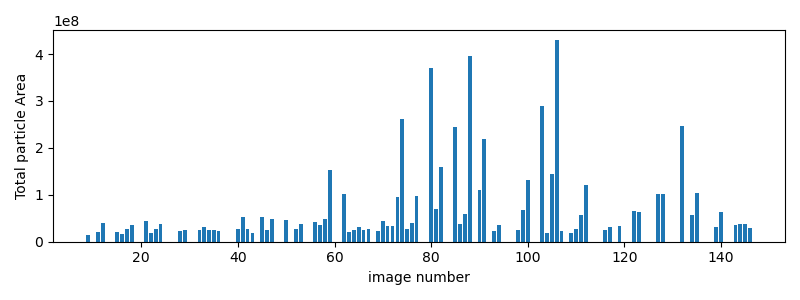

In [145]:
plt.figure(figsize=(8,3))
plt.bar(np.array(order_number_filtered),total_area_filtered,width=0.75)
plt.ylabel('Total particle Area')
plt.xlabel('image number')
plt.tight_layout()


## Separate these flux by particle size (ESD)


In [148]:
large=[]
small=[]
for x in data_filtered['number_list'].unique():
    image_data=data_filtered[data_filtered.number_list==x]
    large_data=image_data[image_data.ESD>500]
    small_data=image_data[image_data.ESD<=500]
    total_large=large_data['Area'].sum()
    total_small=small_data['Area'].sum()
    large.append(total_large)
    small.append(total_small)
    
    

<IPython.core.display.Javascript object>


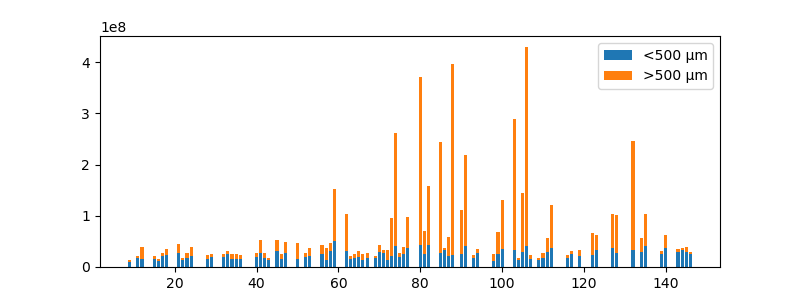

In [149]:
plt.figure(figsize=(8,3))
plt.bar(np.array(order_number_filtered),small,width=0.75,label='<500 µm')
plt.bar(np.array(order_number_filtered),large,width=0.75,bottom=small,label='>500 µm')

plt.legend()

## Increases in flux are caused by large particles
## Export this filtered dataset, manually ID all the largest particles

In [28]:
large_particles_filtered_data=data_filtered[data_filtered.ESD>=500]
#data_filtered.to_csv('/Users/cdurkin/Projects/SnowCam/Snowcam_processed/filtered_particle_measurements.csv')

In [151]:

bins=[]
for x in np.arange(0,40):
    bins.append(2**(x/2))
bin_mids=[]
for x in np.arange(0,len(bins)-1):
    m=bins[x]+((bins[x+1]-bins[x])/2)
    bin_mids.append(m)
PSD=pd.DataFrame(columns=bin_mids)   
for image in data_filtered.file_name.unique():
    i=data_filtered[data_filtered.file_name==image]
    i_hist=np.histogram(i.ESD,bins)
    i_hist_df=pd.DataFrame(i_hist[0]).T
    i_hist_df.columns=bin_mids
    PSD=PSD.append(i_hist_df,ignore_index=True)
    
bin_width=[]
for x in np.arange(0,len(bins)-1):
    w=bins[x+1]-bins[x]
    bin_width.append(w)

<IPython.core.display.Javascript object>


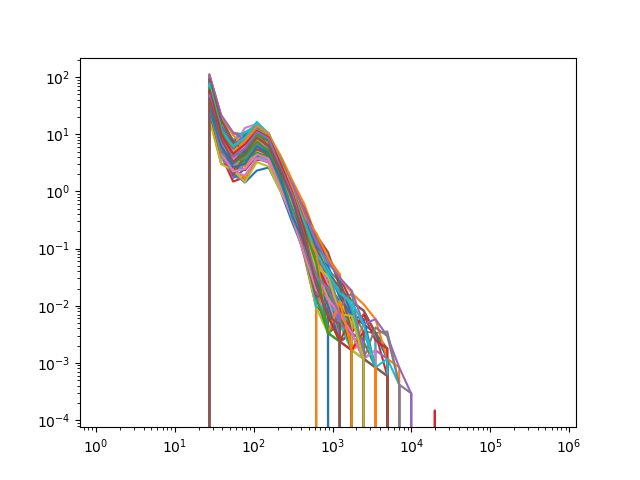

In [152]:
plt.figure()
for x in PSD.index:
    plt.loglog(bin_mids,PSD.loc[x]/bin_width)

In [153]:
data_wID=pd.read_csv('/Users/cdurkin/Projects/SnowCam/Snowcam_processed/filtered_particle_measurements_v2.csv')

In [154]:
agg=[]
dense=[]
fecal=[]
acantharia=[]
copepod=[]
fiber=[]
foram=[]
noise=[]
salps=[]
zoo=[]
total=[]
for x in np.arange(0,len(bins)-1):
    s1=data_wID[data_wID.ESD>bins[x]]
    s2=s1[s1.ESD<bins[x+1]]
    agg.append(len(s2[s2.ID=='aggregate'].index))
    dense.append(len(s2[s2.ID=='dense'].index))
    fecal.append(len(s2[s2.ID=='fecal_pellet'].index))
    acantharia.append(len(s2[s2.ID=='acantharia'].index))
    copepod.append(len(s2[s2.ID=='copepod'].index))
    fiber.append(len(s2[s2.ID=='fiber'].index))
    foram.append(len(s2[s2.ID=='foram'].index))
    noise.append(len(s2[s2.ID=='noise'].index))
    salps.append(len(s2[s2.ID=='salps'].index))
    zoo.append(len(s2[s2.ID=='zooplankton'].index))
    total.append(len(s2.ID))




    

In [155]:
agg_f=np.nan_to_num(np.array(agg)/np.array(total))
acantharia_f=np.nan_to_num(np.array(acantharia)/np.array(total))
copepod_f=np.nan_to_num(np.array(copepod)/np.array(total))
dense_f=np.nan_to_num(np.array(dense)/np.array(total))
fecal_f=np.nan_to_num(np.array(fecal)/np.array(total))
fiber_f=np.nan_to_num(np.array(fiber)/np.array(total))
noise_f=np.nan_to_num(np.array(noise)/np.array(total))
salps_f=np.nan_to_num(np.array(salps)/np.array(total))
zooplankton_f=np.nan_to_num(np.array(zoo)/np.array(total))
foram_f=np.nan_to_num(np.array(foram)/np.array(total))




/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_84245/1881043594.py:1: RuntimeWarning: invalid value encountered in true_divide
  agg_f=np.nan_to_num(np.array(agg)/np.array(total))
/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_84245/1881043594.py:2: RuntimeWarning: invalid value encountered in true_divide
  acantharia_f=np.nan_to_num(np.array(acantharia)/np.array(total))
/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_84245/1881043594.py:3: RuntimeWarning: invalid value encountered in true_divide
  copepod_f=np.nan_to_num(np.array(copepod)/np.array(total))
/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_84245/1881043594.py:4: RuntimeWarning: invalid value encountered in true_divide
  dense_f=np.nan_to_num(np.array(dense)/np.array(total))
/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_84245/1881043594.py:5: RuntimeWarning: invalid value encountered in true_divide
  fecal_f=np.nan_to_num(np.array(fecal)/np.array(total))
/var/folde

<IPython.core.display.Javascript object>


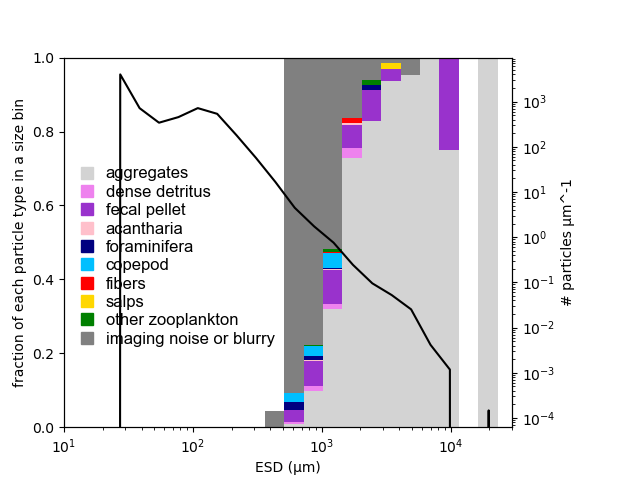

In [159]:
plt.figure()
bottom=np.repeat(0,len(bin_mids))
count=0
color=['lightgrey','violet','darkorchid','pink','navy','deepskyblue','red','gold','green','grey']
for x in [agg_f,dense_f,fecal_f,acantharia_f,foram_f,copepod_f,fiber_f,salps_f,zooplankton_f,noise_f]:
    plt.bar(bin_mids,x,color=color[count],bottom=bottom,width=bin_width)
    bottom=bottom+x
    count=count+1
    plt.xscale('log')
    
plt.xlim(10,30000) 
plt.xlabel('ESD (µm)')
plt.ylabel('fraction of each particle type in a size bin')
plt.twinx()

hist=np.histogram(data_wID.ESD,bins)
plt.loglog(bin_mids,hist[0]/bin_width,color='black')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=color[0],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[1],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[2],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[3],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[4],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[5],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[6],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[7],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[8],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[9],marker = 's',lw=0,ms=8)]
plt.legend(custom_lines,['aggregates','dense detritus','fecal pellet','acantharia','foraminifera','copepod','fibers','salps','other zooplankton','imaging noise or blurry'],labelspacing=0.2,handletextpad=0.1,frameon=False,loc=[0,0.2],prop={'family':'Arial','size':12})
plt.ylabel('# particles µm^-1')

plt.subplots_adjust(left=0.1,right=0.8)



## Graph above shows PSD slope for the entire image dataset pooled together

## I only classified particles >500 µm. As particles get smaller, a greater proportion are known imaging noise (not real particles), or else too blurry to tell if it is real or not.

In [160]:
agg_area=[]
fp_area=[]
noise_area=[]
dense_area=[]
acantharia_area=[]
foram_area=[]
copepod_area=[]
salp_area=[]
fiber_area=[]
zoo_area=[]
small_area=[]
for x in data_wID['number_list'].unique():
    image_data=data_wID[data_wID.number_list==x]
    agg_area.append(image_data[image_data.ID=='aggregate']['Area'].sum())
    fp_area.append(image_data[image_data.ID=='fecal_pellet']['Area'].sum())
    noise_area.append(image_data[image_data.ID=='noise']['Area'].sum())
    dense_area.append(image_data[image_data.ID=='dense']['Area'].sum())
    acantharia_area.append(image_data[image_data.ID=='acantharia']['Area'].sum())
    foram_area.append(image_data[image_data.ID=='foram']['Area'].sum())
    copepod_area.append(image_data[image_data.ID=='copepod']['Area'].sum())
    salp_area.append(image_data[image_data.ID=='salp']['Area'].sum())
    zoo_area.append(image_data[image_data.ID=='zooplankton']['Area'].sum())
    fiber_area.append(image_data[image_data.ID=='fiber']['Area'].sum())
    small_area.append(image_data[image_data.ID=='0.0']['Area'].sum())



<IPython.core.display.Javascript object>


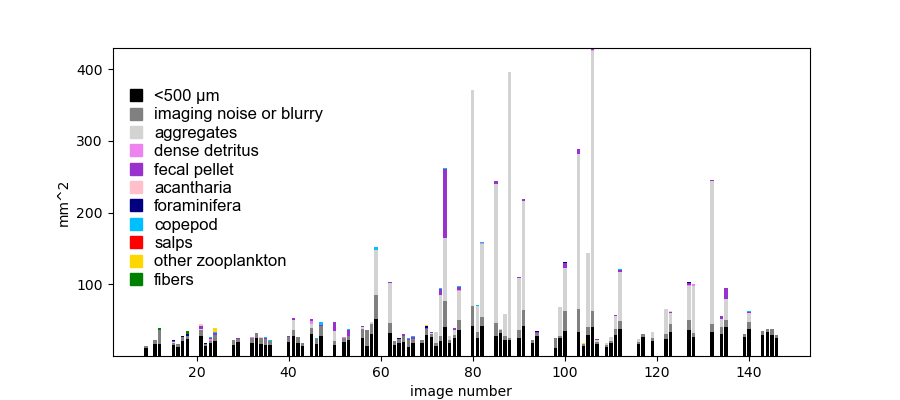

Text(0.5, 0, 'image number')

In [161]:
bottom=np.repeat(0,len(order_number_filtered))
plt.figure(figsize=(9,4))
plt.bar(np.array(order_number_filtered),small_area,width=0.75,color='black')
bottom=bottom+small_area
plt.bar(np.array(order_number_filtered),noise_area,bottom=bottom,width=0.75,color=color[9])
bottom=bottom+noise_area
plt.bar(np.array(order_number_filtered),agg_area,width=0.75,bottom=bottom,color=color[0])
bottom=bottom+agg_area
plt.bar(np.array(order_number_filtered),dense_area,bottom=bottom,width=0.75,color=color[1])
bottom=bottom+dense_area
plt.bar(np.array(order_number_filtered),fp_area,bottom=bottom,width=0.75,color=color[2])
bottom=bottom+fp_area
plt.bar(np.array(order_number_filtered),acantharia_area,bottom=bottom,width=0.75,color=color[3])
bottom=bottom+acantharia_area
plt.bar(np.array(order_number_filtered),foram_area,bottom=bottom,width=0.75,color=color[4])
bottom=bottom+foram_area
plt.bar(np.array(order_number_filtered),copepod_area,bottom=bottom,width=0.75,color=color[5])
bottom=bottom+copepod_area
plt.bar(np.array(order_number_filtered),salp_area,bottom=bottom,width=0.75,color=color[6])
bottom=bottom+salp_area
plt.bar(np.array(order_number_filtered),zoo_area,bottom=bottom,width=0.75,color=color[7])
bottom=bottom+zoo_area
plt.bar(np.array(order_number_filtered),fiber_area,bottom=bottom,width=0.75,color=color[8])
bottom=bottom+fiber_area



from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black',marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[9],marker = 's',lw=0,ms=8),
                Line2D([0], [0], color=color[0],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[1],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[2],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[3],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[4],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[5],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[6],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[7],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=color[8],marker = 's',lw=0,ms=8)]
plt.legend(custom_lines,['<500 µm','imaging noise or blurry','aggregates','dense detritus','fecal pellet','acantharia','foraminifera','copepod','salps','other zooplankton','fibers'],labelspacing=0.2,handletextpad=0.1,frameon=False,loc=[0,0.2],prop={'family':'Arial','size':12})

plt.yticks([100000000,200000000,300000000,400000000],['100','200','300','400'])
plt.ylabel('mm^2')
plt.xlabel('image number')

## Particles smaller than 500 µm don't vary much over the time series.  Blurry/noise also doesn't very much (except in a couple images, though that could be true noise artifact too).

## It seems to me that the Snowcam currently detects fluxes of particles >500 µm, are does really well for particles >1 mm.  Anything smaller than this is most likely imaging noise (scratches, glare) or imperfectly detected particles, with a small fraction that is actual particles too small to visually resolve the ID.

## This iteration of analysis used an image mask that tried to eliminate the most egrigious areas of the imaging plate that had consistant noise.

## That effective image area = 3930004 square pixels
## Scale is 2500 pixels per 52 mm, so effective flux observations occur over 1700 mm^2
## (total image area is 2123 mm^2, so masking removed 20% of the observable area)

In [166]:
3930004/((2500/52)**2)

1700.27693056